# **Classifying face images with SVM**


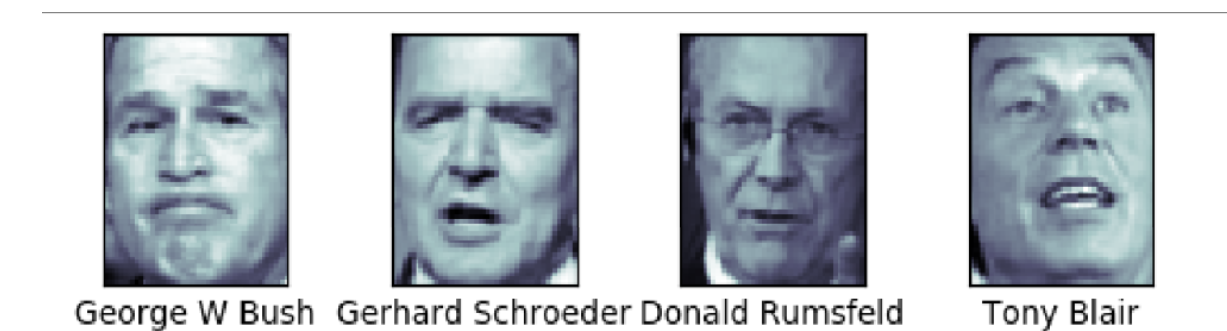

### **source:**
Yuxi Liu - Python for Machine Learning


In this tutorial we will be using **Support Vector Machine**, **Principal Component Analysis**, **GridSearch Cross Validation** and **Pipelining** in Machine Learning:




<h3><b>SVM:</b></h3>
Is effective in cases with high-dimensional spaces or where the number of dimensions is greater than the number of samples.

**Dataset:**  <a href ="https://scikitlearn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html">Labeled Faces in the Wild (LFW) people dataset</a> It consists of more than 13,000 curated face images of more than 5,000 famous people. Each class has various numbers of image samples

### Import all necessary libraries:

In [97]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split # train test split of the data
from sklearn.svm import SVC # classifier
from sklearn.model_selection import GridSearchCV # crossvalidation
# import the evaluation metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, \
f1_score, classification_report,ConfusionMatrixDisplay, roc_curve # for model evaluation


### 1. First, we load the face image data as follows:

In [2]:
# load the dataset from sklearn
from sklearn.datasets import fetch_lfw_people

In [3]:
face_data = fetch_lfw_people(min_faces_per_person=80)

We only load classes with at least 80 samples so that we will have enough training data. Note that if you run into the problem of ImportError: The Python Imaging Library (PIL) is required to load data from JPEG files, please install the package pillow as follows in the terminal:

In [4]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


###  2. Next, we take a look at the data we loaded:

In [5]:
# input features assign to X
X = face_data.data

In [6]:
# target to Y
Y = face_data.target

In [7]:
# print the shape of X
print('Input data size :', X.shape)

Input data size : (1140, 2914)


In [8]:
# print the shape of Y
print('Output data size :', Y.shape)

Output data size : (1140,)


In [9]:
print('Label names:', face_data.target_names)

Label names: ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


This five-class dataset contains 1,140 samples and a sample is of 2,914 dimensions. As a good practice, we analyze the label distribution as follows:

In [10]:
for i in range(5): 
   print(f'Class {i} has {(Y == i).sum()} samples.')

Class 0 has 236 samples.
Class 1 has 121 samples.
Class 2 has 530 samples.
Class 3 has 109 samples.
Class 4 has 144 samples.


The dataset is rather imbalanced. Let's keep this in mind when we build the model.

Now let's plot a few face images:

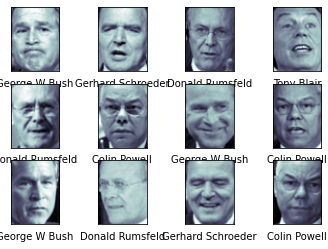

In [11]:
fig, ax = plt.subplots(3, 4)
for i, axi in enumerate(ax.flat):
    axi.imshow(face_data.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=face_data.target_names[face_data.target[i]])
plt.show()    

Now that we have covered exploratory data analysis, we will move on to the model development phase in the next section.

### 3. Split the data into the training and testing set:

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

###  4. We can now apply the SVM classifier to the data. We first initialize an SVC model and fit it against the training set:

In this project, the number of dimensions is greater than the number of samples. This is a classification case that SVM is effective at solving. In our solution, we will tune the hyperparameters, including the penalty C, the kernel (linear or RBF), and 𝛾𝛾 (for the RBF kernel) through cross-validation.

**We then initialize a common SVM model:**

In [13]:
clf = SVC(class_weight='balanced', random_state=42)

The dataset is **imbalanced**, so we set **class_weight='balanced'** to emphasize the underrepresented classes.


The way we have conducted **cross-validation** so far is to explicitly split data into folds and repetitively write a for loop to consecutively examine each **hyperparameter**. To make this less redundant, we'll introduce a more elegant approach utilizing the GridSearchCV module from scikit-learn. **GridSearchCV** handles the entire process implicitly, including data splitting, fold generation, cross training and validation, and finally, an exhaustive search over the best set of parameters. What is left for us is just to specify the hyperparameter(s) to tune and the values to explore for each individual hyperparameter: **- Yuxi Liu**

In [14]:
parameters = {'C': [0.1, 1, 10],
            'gamma': [1e-07, 1e-08, 1e-06],
              'kernel' : ['rbf', 'linear'] }

**GridSearchCV:**

In [15]:
grid_search = GridSearchCV(clf, parameters, n_jobs=-1, cv=5)

The **GridSearchCV model** we just initialized will conduct five-fold cross-validation **(cv=5)** and will run in parallel on all available cores **(n_jobs=-1)**. We then perform hyperparameter tuning by simply applying the fit method:

In [16]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1e-07, 1e-08, 1e-06],
                         'kernel': ['rbf', 'linear']})

We obtain the optimal set of hyperparameters using the following code:

In [17]:
print('The best model:\n', grid_search.best_params_)

The best model:
 {'C': 1, 'gamma': 1e-07, 'kernel': 'linear'}


### Best parameters and model evaluation

And we obtain the best five-fold averaged performance under the optimal set of parameters by using the following code:

In [18]:
print('The best averaged performance:', grid_search.best_score_) 

The best averaged performance: 0.8304093567251462


We then retrieve the SVM model with the optimal set of hyperparameters and apply it to the testing set:

In [19]:
clf_best = grid_search.best_estimator_

In [20]:
pred = clf_best.predict(X_test)

We then calculate the accuracy and classification report:

In [21]:
print(f'The accuracy is: {clf_best.score(X_test,Y_test)*100:.1f}%')

The accuracy is: 87.7%


**Classification report:**

In [22]:
# classification report
print(classification_report(Y_test, pred, target_names=face_data.target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.89      0.88      0.88        64
  Donald Rumsfeld       0.89      0.78      0.83        32
    George W Bush       0.87      0.91      0.89       127
Gerhard Schroeder       0.89      0.86      0.88        29
       Tony Blair       0.88      0.85      0.86        33

         accuracy                           0.88       285
        macro avg       0.88      0.86      0.87       285
     weighted avg       0.88      0.88      0.88       285



**Confusion Matrix:**

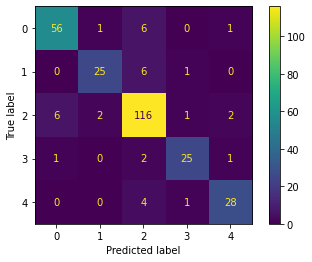

In [23]:
cm = confusion_matrix(Y_test, pred, labels=clf_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf_best.classes_)
disp.plot()
plt.show()

**F1_score, Precision, Accuracy, Recall:**

In [24]:
svm_f1 = f1_score(Y_test, pred, average='weighted')
svm_accuracy = accuracy_score(Y_test, pred)
svm_precision = precision_score(Y_test, pred, average='micro')
svm_recall = recall_score(Y_test, pred, average='micro')

print("Avg F1-score: %.4f" % svm_f1)
print("Accuracy: %.4f" % svm_accuracy)
print("Precision: %.4f" % svm_precision)
print("Recall: %.4f" % svm_recall)

Avg F1-score: 0.8767
Accuracy: 0.8772
Precision: 0.8772
Recall: 0.8772


**Report:**

In [25]:
metric = {
  "Accuracy": [str(round(svm_f1*100,2))+"%"],
  "F1 score" : [str(round(svm_accuracy*100,2))+"%"],
  "Precision": [str(round(svm_precision*100,2))+"%"],
  "Recall": [str(round(svm_recall*100,2))+"%"]
}


Report = pd.DataFrame(metric)
Report = Report.rename(index={ 0:'Support Vector Machine'})

In [26]:
Report

,Accuracy,F1 score,Precision,Recall
Support Vector Machine,87.67%,87.72%,87.72%,87.72%


# Boosting image classification performance with PCA

We can also improve the image classifier by compressing the input features with **principal component analysis (PCA)** (https://en.wikipedia.org/wiki/Principal_ component_analysis). It reduces the dimension of the original feature space and preserves the most important internal relationships among features. In simple terms, PCA projects the original data into a smaller space with the most important directions (coordinates). We hope that in cases where we have more features than training samples, considering fewer features as a result of dimensionality reduction using PCA can prevent **overfitting**.


We will implement PCA with the PCA module (https://scikit-learn.org/stable/ modules/generated/sklearn.decomposition.PCA.html) from scikit-learn. We will first apply PCA to reduce the dimensionality and train the classifier on the resulting data. In machine learning, we usually concatenate multiple consecutive steps and treat them as one "model." We call this process **pipelining**. We utilize the pipeline API (https://scikit-learn.org/stable/modules/generated/sklearn.pipeline. Pipeline.html) from scikit-learn to facilitate this. **- Yuxi Liu**

### Now let's initialize a PCA model, an SVC model, and a model pipelining these two:

In [79]:
# sklearn PCA API
from sklearn.decomposition import PCA
pca = PCA(n_components=100, whiten=True, random_state=42)
svc = SVC(class_weight='balanced', kernel='rbf', random_state=42, probability=True)

In [80]:
# sklearn pipeline API
from sklearn.pipeline import Pipeline
model = Pipeline([('pca', pca),
                  ('svc', svc)])

The PCA component projects the original data into a 100-dimension space, followed by the SVC classifier with the RBF kernel. We then grid search for the best model from a few options:

In [81]:
# pipelining the model
parameters_pipeline = {'svc__C': [1, 3, 10, 15],
                       'svc__gamma': [0.001, 0.005, 0.009]}


# instantiate the model
grid_search = GridSearchCV(model, parameters_pipeline)

# fit the grid search model
grid_search.fit(X_train, Y_train)

GridSearchCV(estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=100, random_state=42,
                                            whiten=True)),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            probability=True,
                                            random_state=42))]),
             param_grid={'svc__C': [1, 3, 10, 15],
                         'svc__gamma': [0.001, 0.005, 0.009]})

Finally, we print out the best set of hyperparameters and the classification performance with the best model:

In [82]:
print('The best model:\n', grid_search.best_params_)

The best model:
 {'svc__C': 1, 'svc__gamma': 0.009}


In [83]:
print('The best averaged performance:', grid_search.best_score_)

The best averaged performance: 0.8584795321637427


In [84]:
model_best = grid_search.best_estimator_

In [85]:
# our model's accuracy
print(f'The accuracy is: {model_best.score(X_test, Y_test)*100:.1f}%')

The accuracy is: 91.9%


In [86]:
# model's prediction
pred = model_best.predict(X_test)

**Classification report:**

In [87]:
print(classification_report(Y_test, pred, target_names=face_data.target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.94      0.94      0.94        64
  Donald Rumsfeld       0.90      0.84      0.87        32
    George W Bush       0.92      0.96      0.94       127
Gerhard Schroeder       0.88      0.79      0.84        29
       Tony Blair       0.94      0.91      0.92        33

         accuracy                           0.92       285
        macro avg       0.92      0.89      0.90       285
     weighted avg       0.92      0.92      0.92       285



**Confusion Matrix:**

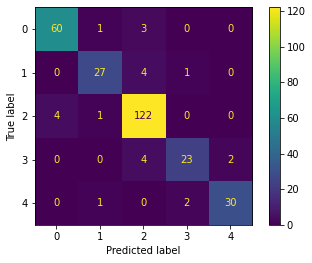

In [88]:
cm = confusion_matrix(Y_test, pred, labels=model_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model_best.classes_)
disp.plot()
plt.show()

**F1_score, Precision, Accuracy, Recall:**

In [92]:
svm_f1 = f1_score(Y_test, pred, average='weighted')
svm_accuracy = accuracy_score(Y_test, pred)
svm_precision = precision_score(Y_test, pred, average='micro')
svm_recall = recall_score(Y_test, pred, average='micro')

print("Avg F1-score: %.4f" % svm_f1)
print("Accuracy: %.4f" % svm_accuracy)
print("Precision: %.4f" % svm_precision)
print("Recall: %.4f" % svm_recall)

Avg F1-score: 0.9185
Accuracy: 0.9193
Precision: 0.9193
Recall: 0.9193


**Report after PCA and GridSearch CV:**

In [102]:
metric = {
  "Accuracy": [str(round(svm_f1*100,2))+"%"],
  "F1 score" : [str(round(svm_accuracy*100,2))+"%"],
  "Precision": [str(round(svm_precision*100,2))+"%"],
  "Recall": [str(round(svm_recall*100,2))+"%"]
}


Report = pd.DataFrame(metric)
Report = Report.rename(index={ 0:'PCA and SVM'})

In [103]:
Report

,Accuracy,F1 score,Precision,Recall
PCA and SVM,91.85%,91.93%,91.93%,91.93%


### **save the model:**

In [104]:
import pickle
# saving the model
pickle.dump(model_best, open('model_best.pkl','wb'))

# Loading model to compare the results
model = pickle.load(open('model_best.pkl','rb'))

## For more about the theory of support vector machine please refer to the book of

**Python Machine Learning By Example:** Chapter 3

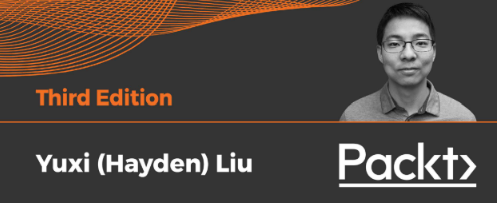